#### Импорты

In [1]:
import sys
sys.path.insert(0, "src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import z_score_normalize
from src.model import MyLinearRegression
from src.metrics import mse, r2

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

print("Библиотеки загружены.")

Библиотеки загружены.


#### Анализ данных

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("train shape:", train.shape)
print("test shape:", test.shape)

train.head(8)

train shape: (11017, 35)
test shape: (5000, 35)


ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   
5      1997-05-12  21.0       15000.0        300.0     29786.0          48.0   
6      1987-04-06  32.0      300000.0        850.0     89073.0          36.0   
7      1989-05-09  38.0      191474.0        600.0      6706.0          72.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                562.0   
5        Single                 4.0                Rent                457.0   
6       Married                 1.0                Rent                 82.0   
7       Married                 0.0                Rent                153.0   

   ...  JobTenure  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0  ...        4.0          Employed       Associate         4.0   35067.0   
1  ...        2.0          Employed     High School        33.0   27001.0   
2  ...        3.0          Employed        Bachelor        28.0  278382.0   
3  ...        3.0          Employed     High School         0.0    9224.0   
4  ...        5.0          Employed        Bachelor        31.0    4502.0   
5  ...        4.0     Self-Employed     High School         0.0   53845.0   
6  ...        4.0          Employed       Associate        12.0   12910.0   
7  ...        4.0          Employed     High School        13.0    4777.0   

  BaseInterestRate  InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0         0.257790      0.251465          508.970230                0.288013   
1         0.086110      0.093173          514.675859                0.050585   
2         0.108436      0.115443         1268.276385                0.072571   
3         0.100686      0.112822          498.505187                0.225415   
4         0.110437      0.089037          756.035156                0.052721   
5         0.384786      0.404018         1259.904560                1.373524   
6         0.159073      0.150327         3089.170736                0.126847   
7         0.231706      0.262994          186.024237                0.021247   

   RiskScore  
0  66.176500  
1  28.495737  
2  34.488104  
3  36.910753  
4  31.347091  
5  64.365309  
6  38.910949  
7  39.895288  

[8 rows x 35 columns]

In [3]:
print("train dtypes:")
print(train.dtypes.value_counts())
print()
print("missing in train:")
missing_train = train.isnull().sum()
print(missing_train[missing_train > 0].sort_values(ascending=False))

print("\nmissing in test:")
missing_test = test.isnull().sum()
print(missing_test[missing_test > 0])

train dtypes:
float64    29
object      6
Name: count, dtype: int64

missing in train:
TotalAssets                   1031
CreditScore                   1031
LoanAmount                    1031
BaseInterestRate              1031
NetWorth                      1031
MonthlyDebtPayments           1031
CheckingAccountBalance        1031
LoanPurpose                   1031
BankruptcyHistory             1031
JobTenure                      530
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
ApplicationDate                530
EmploymentStatus               530
EducationLevel                 530
InterestRate                   530
MonthlyLoanPayment             530
TotalDebtToIncomeRatio         530
Experience                     530
PaymentHistory                 530
SavingsAccountBalance          530
LengthOfCreditHistory          530
Age                            530
PreviousLoanDefaults           530
DebtToIncomeRatio              530
Num

In [4]:
def analyze_risk_score(train):

    plt.figure(figsize=(6, 4))
    sns.histplot(train["RiskScore"], bins=100, color="steelblue")
    plt.title("RiskScore distribution")
    plt.xlabel("RiskScore")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

    print(train["RiskScore"].describe())

In [ ]:
def analyze_feauters(df, target_col="RiskScore", max_scatters=9, max_hists=9, max_corr_features=30):
    """
    Визуализирует данные.
    - max_corr_features: Топ N признаков для отображения в матрицах корреляции.
      Они будут разбиты на группы по 15 штук.
    """
    # Работаем только с числами
    numeric_df = df.select_dtypes(include=[np.number]).copy()
    
    if target_col not in numeric_df.columns:
        print(f"Целевая колонка '{target_col}' не найдена.")
        return

    # Считаем корреляции
    corr = numeric_df.corr()
    risk_corr = corr[target_col].abs().sort_values(ascending=False)
    
    # 1. Correlation Matrices
    all_features = risk_corr.index.tolist()
    if target_col in all_features:
        all_features.remove(target_col)
    
    # Обрезаем список по желанию пользователя
    features_to_show = all_features[:max_corr_features]
    
    # Разбиваем на чанки по 15
    chunk_size = 15
    feature_chunks = [features_to_show[i:i + chunk_size] for i in range(0, len(features_to_show), chunk_size)]
    
    print(f"\n--- Correlation Matrices (Top {len(features_to_show)} features split by 15) ---")
    
    for i, chunk in enumerate(feature_chunks):
        # Добавляем таргет в каждый чанк для контекста
        features_in_chunk = chunk + [target_col]
        corr_chunk = corr.loc[features_in_chunk, features_in_chunk]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            corr_chunk,
            annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True,
            cbar_kws={"shrink": 0.8},
        )
        plt.title(f"Correlation Matrix - Group {i+1} (Features {i*chunk_size + 1}-{min((i+1)*chunk_size, len(features_to_show))})")
        plt.tight_layout()
        plt.show()

    # 2. Scatter (топ)
    scatter_features = risk_corr.index[1:max_scatters+1]
    n_scatters = len(scatter_features)
    
    if n_scatters > 0:
        cols = 3
        rows = (n_scatters + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        axes = axes.flatten()
        
        for i, feature in enumerate(scatter_features):
            sns.scatterplot(data=df, x=feature, y=target_col, ax=axes[i], alpha=0.4, s=15, color='steelblue')
            r = numeric_df[feature].corr(numeric_df[target_col])
            axes[i].set_title(f"{feature} vs {target_col}\n(corr = {r:+.3f})")
            axes[i].grid(True, alpha=0.3)
            
        for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
        plt.suptitle(f"Top {n_scatters} Scatter Plots", y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()

    # 3. Histograms (топ)
    skewness = numeric_df.apply(lambda x: x.skew()).abs().sort_values(ascending=False)
    hist_features = skewness.index[:max_hists]
    n_hists = len(hist_features)
    
    if n_hists > 0:
        cols = 3
        rows = (n_hists + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        axes = axes.flatten()
        
        for i, feature in enumerate(hist_features):
            sns.histplot(data=df, x=feature, ax=axes[i], bins=40, kde=True, color='darkorange')
            skew_val = df[feature].skew()
            axes[i].set_title(f"{feature}\n(skew = {skew_val:+.2f})")
            axes[i].grid(True, alpha=0.3)
            
        for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
        plt.suptitle(f"Top {n_hists} Skewed Distributions", y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()

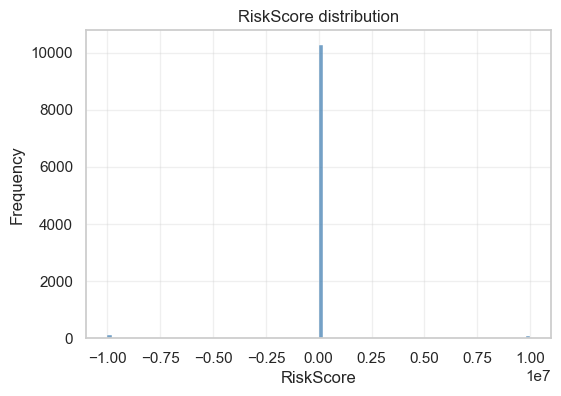

count    1.048700e+04
mean    -2.569878e+04
std      1.431675e+06
min     -9.999999e+06
25%      3.256475e+01
50%      4.411876e+01
75%      6.535690e+01
max      1.000000e+07
Name: RiskScore, dtype: float64

--- Correlation Matrices (Top 10 features split by 15) ---


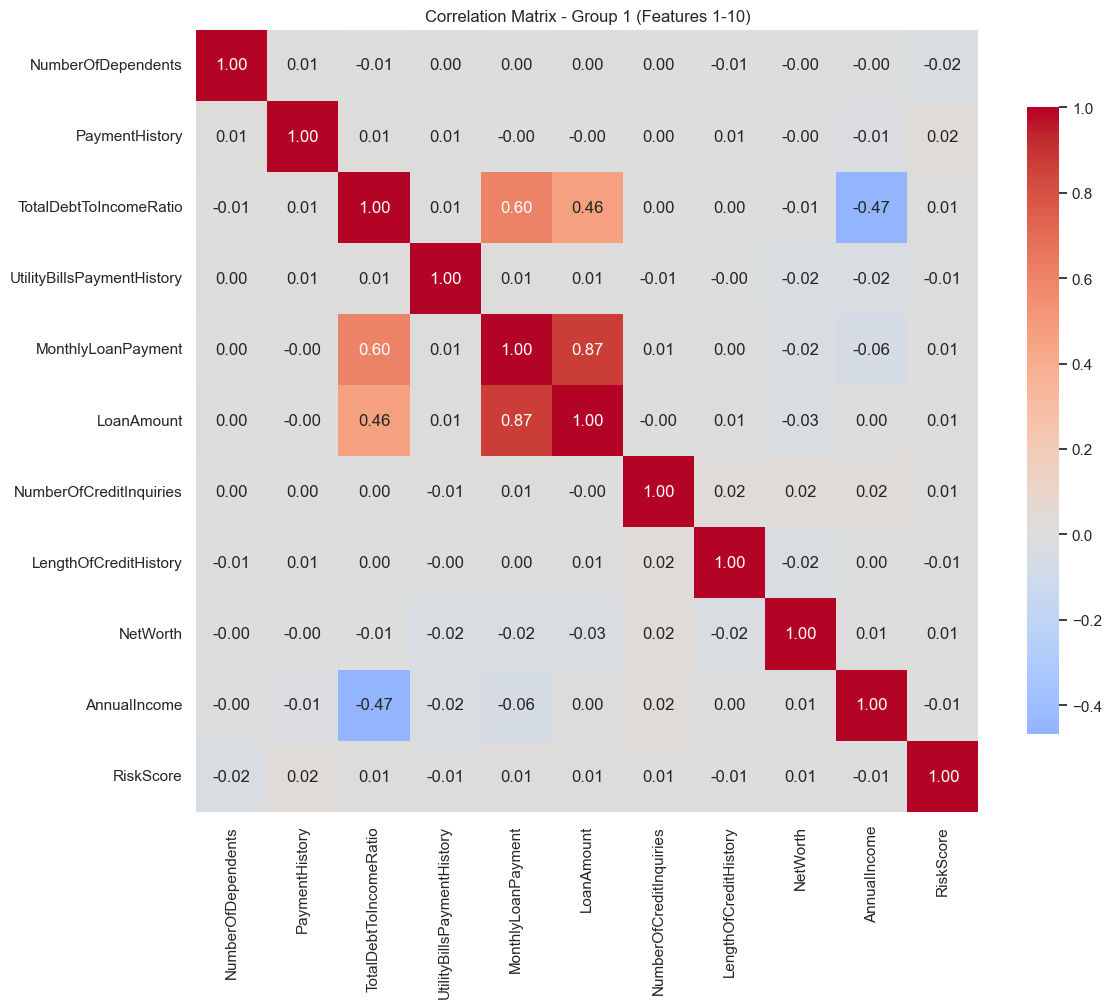

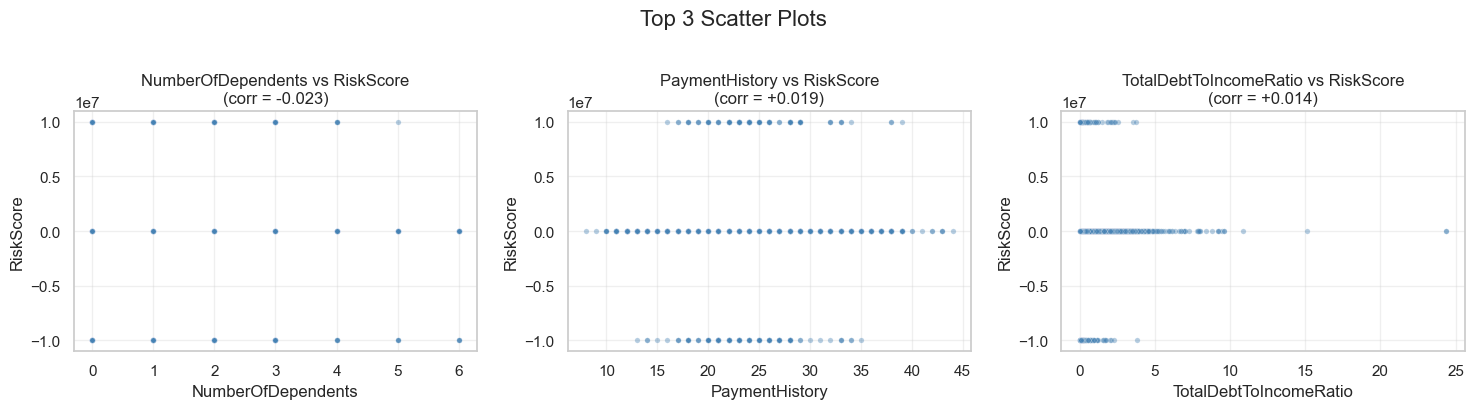

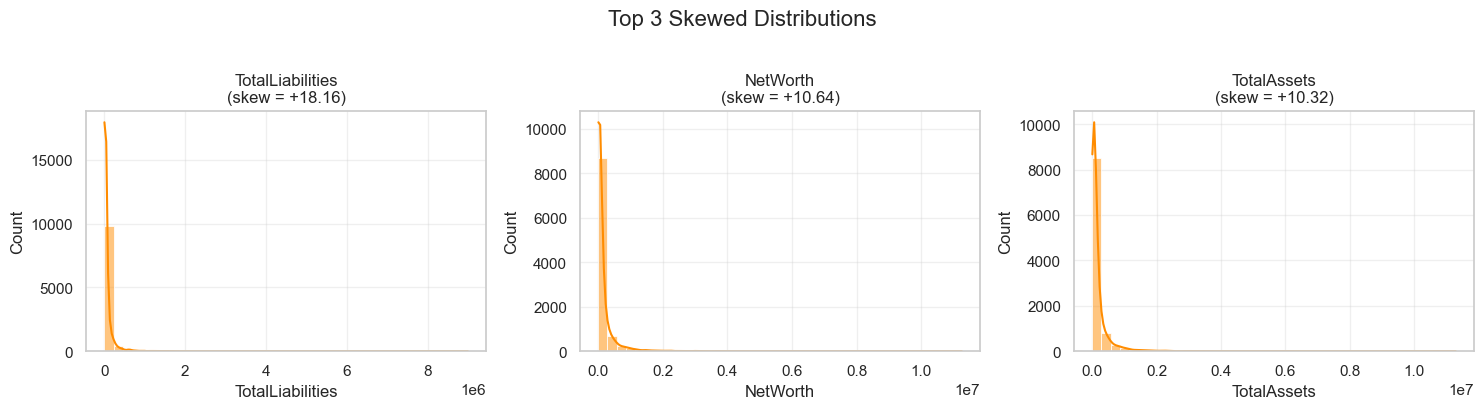

In [6]:
analyze_risk_score(train)
analyze_feauters(train, max_scatters=3, max_hists=3, max_corr_features=10)


Есть грязь, поэтому очищаем и визуализируем еще раз

In [ ]:
train_clean = train.copy()
train_clean["RiskScore"] = train_clean["RiskScore"].replace([-9999999, 10000000], np.nan)

train_clean = train_clean.dropna(subset=["RiskScore"]).reset_index(drop=True)

print("Исходный размер:", len(train))
print("После очистки:", len(train_clean))


Исходный размер: 11017
После очистки: 10272


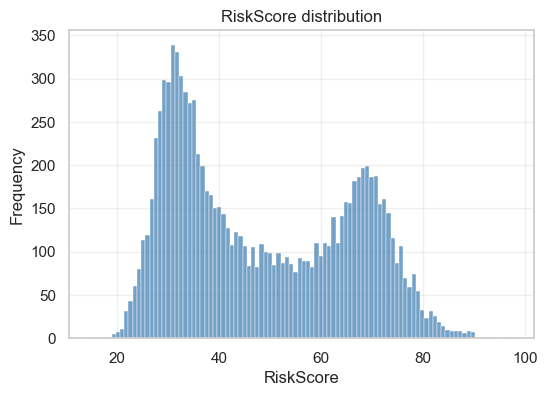

count    10272.000000
mean        48.358094
std         17.241456
min         14.841417
25%         32.722756
50%         44.195792
75%         65.124190
max         97.597249
Name: RiskScore, dtype: float64

--- Correlation Matrices (Top 28 features split by 15) ---


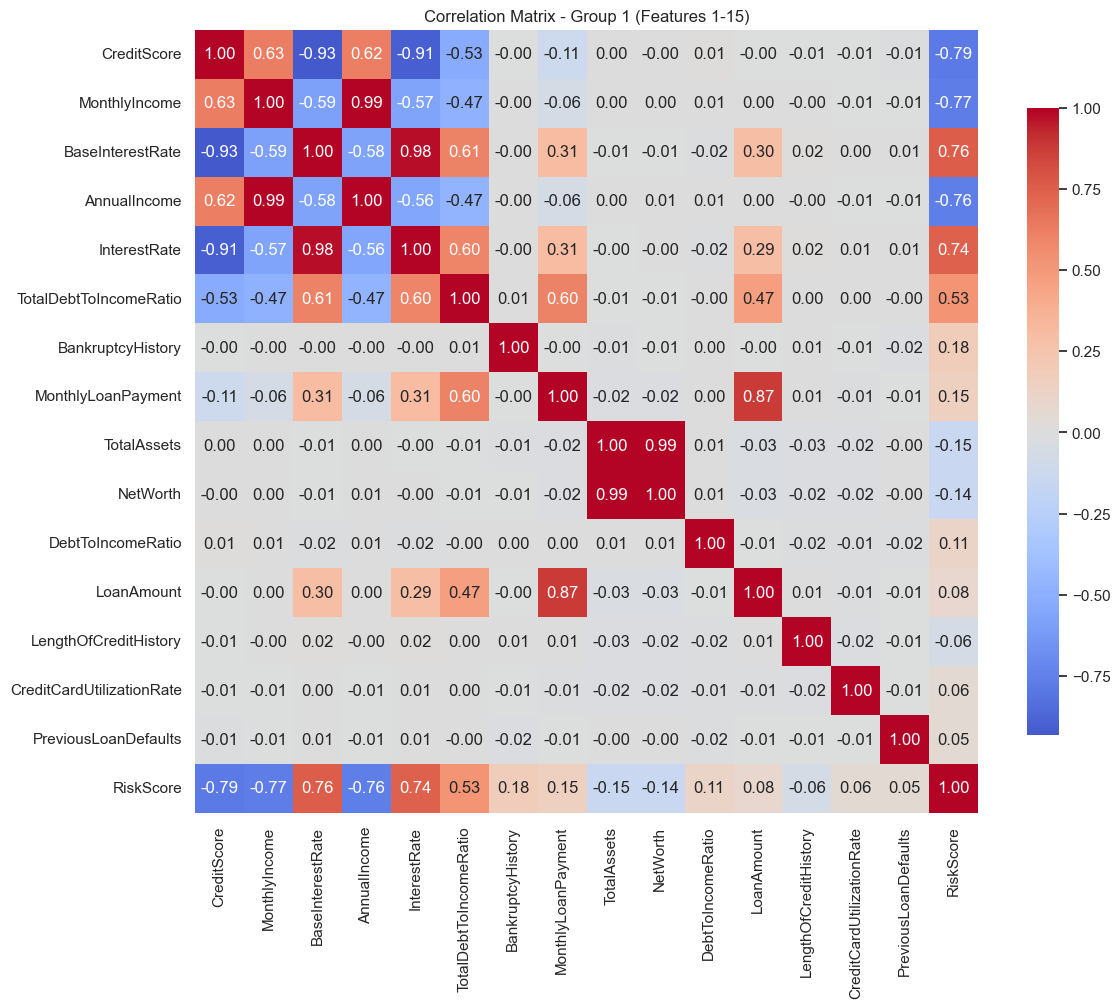

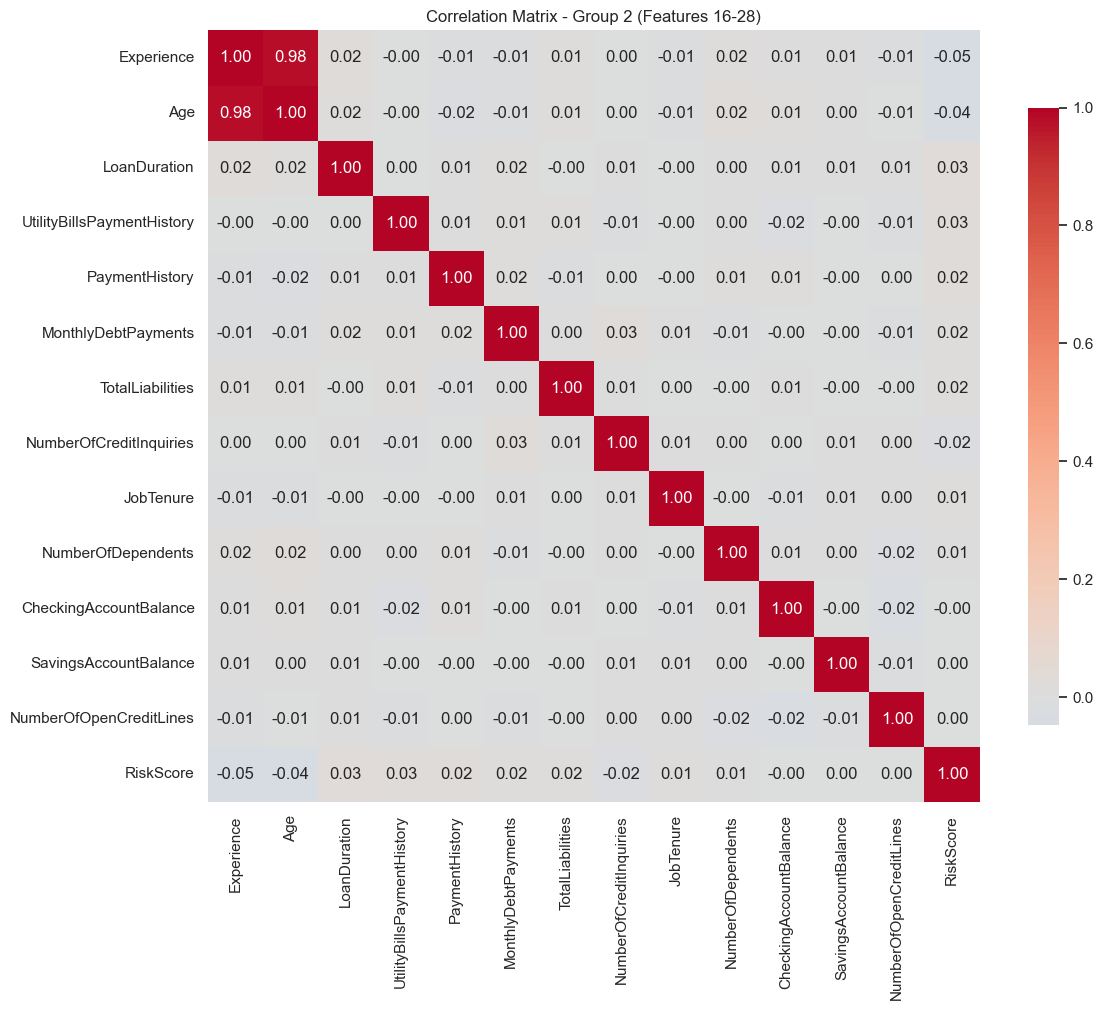

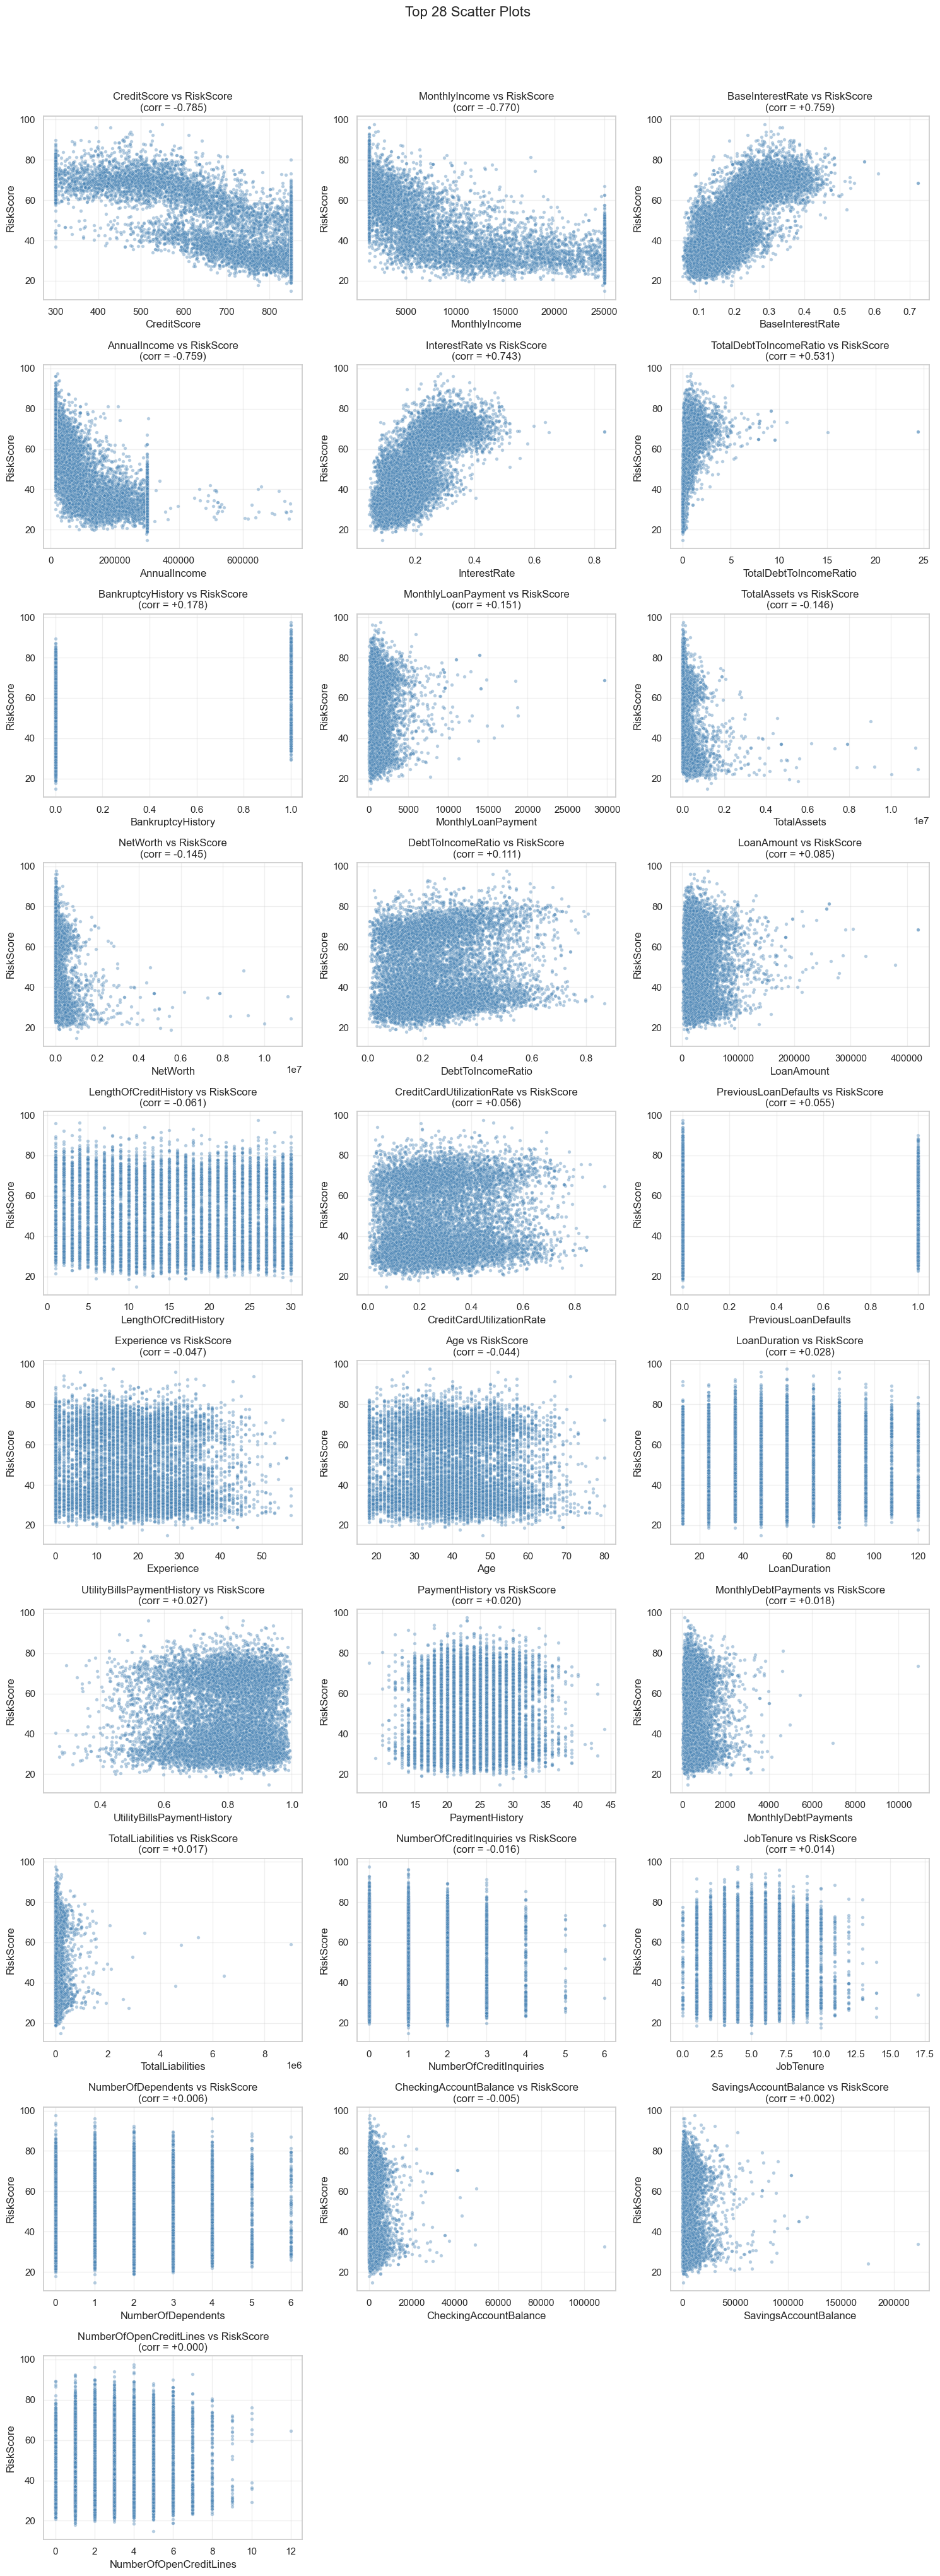

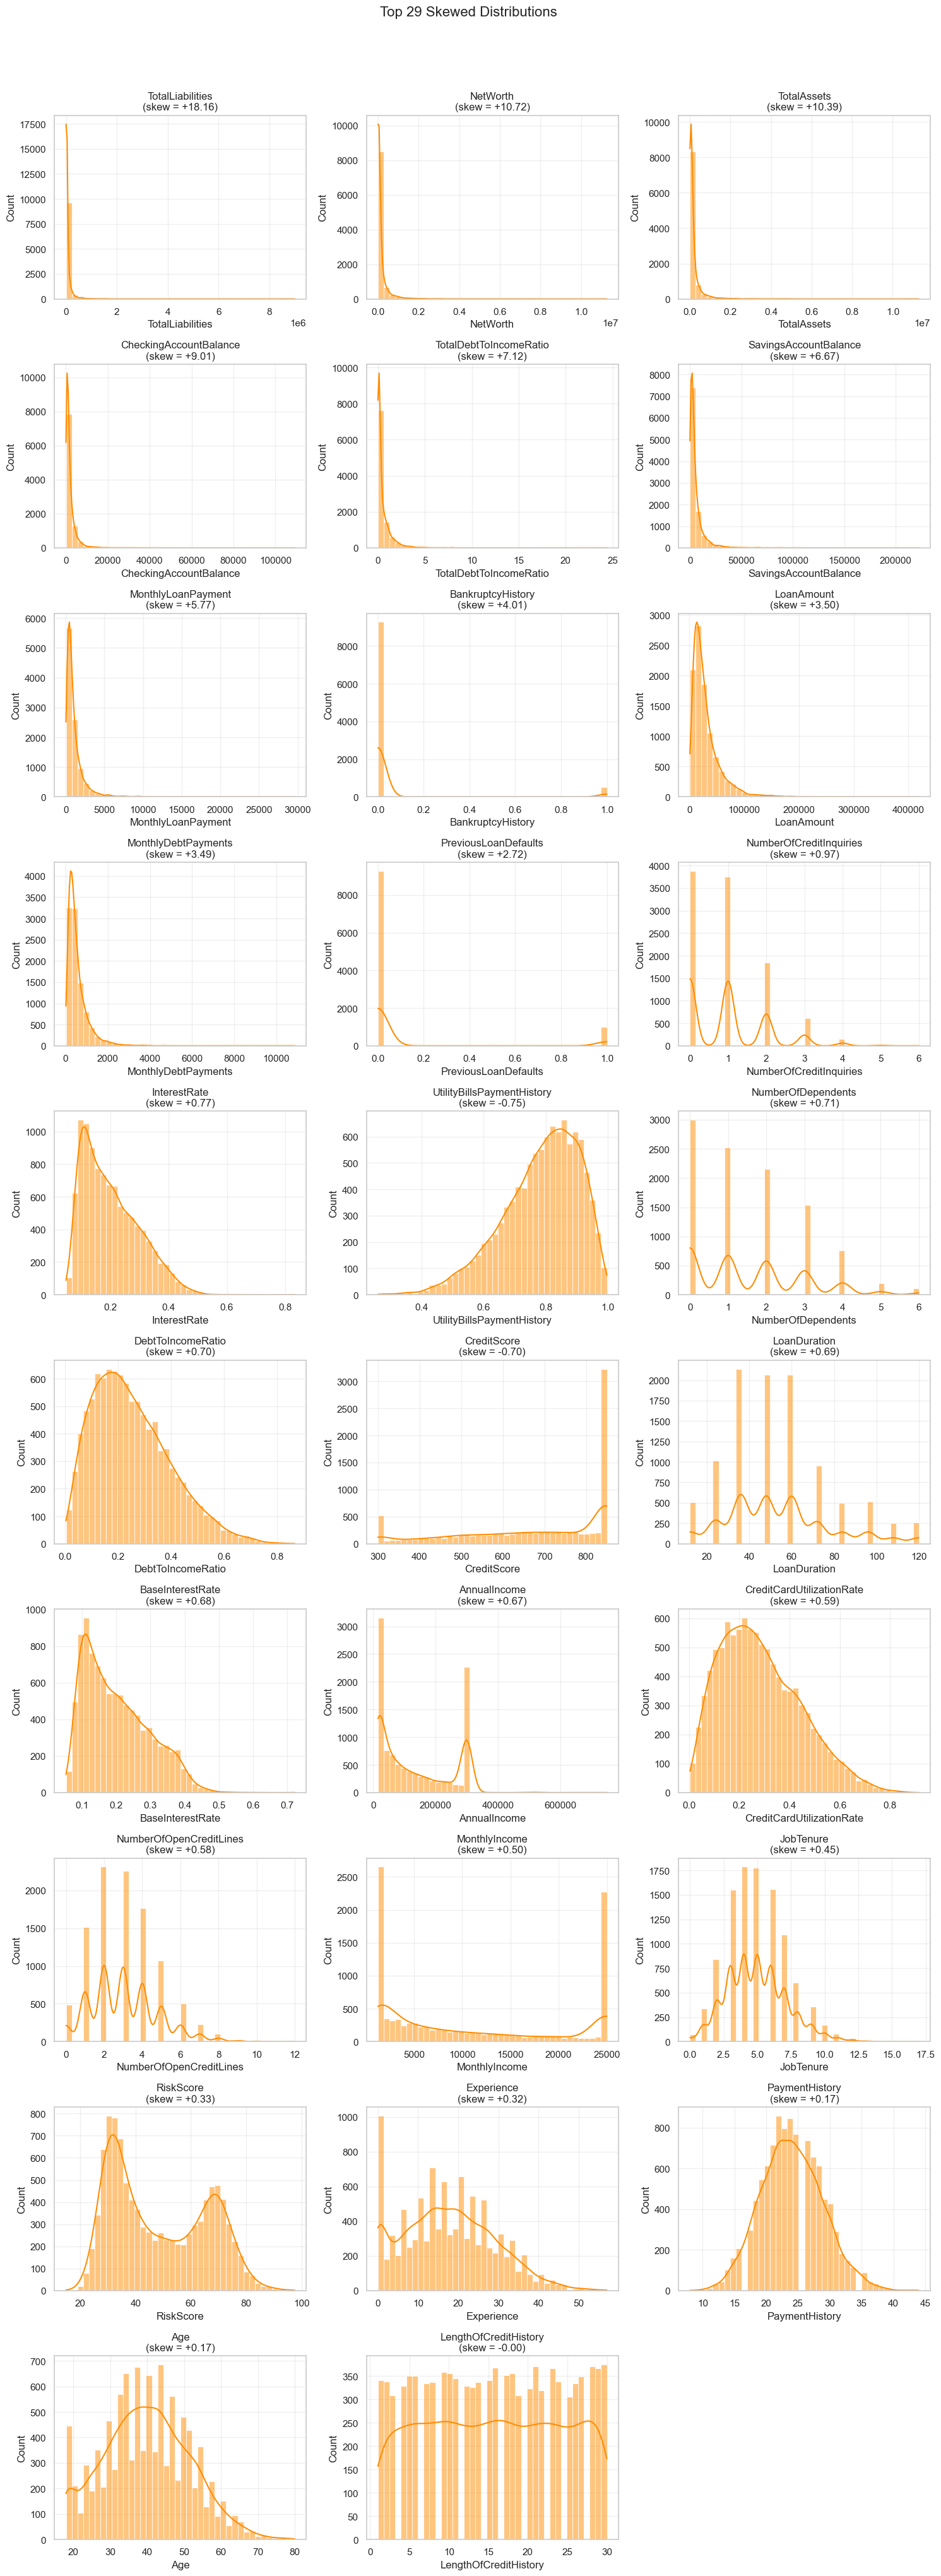

In [8]:
analyze_risk_score(train_clean)
analyze_feauters(train_clean, max_scatters=30, max_hists=30, max_corr_features=30)

#### Тестируем метрики

In [9]:
from src.metrics import mse, mae, r2, mape
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

y_true = np.array([4.2, -0.5, 10.0, -3.0])
y_pred = np.array([7.0, 5.0, -3.3, 0.0])

print(
    f"MSE:\n"
    f"my: {mse(y_true, y_pred)}\n"
    f"sklearn: {mean_squared_error(y_true, y_pred)}\n"
)

print(
    f"MAE:\n"
    f"my: {mae(y_true, y_pred)}\n"
    f"sklearn: {mean_absolute_error(y_true, y_pred)}\n"
)

print(
    f"R^2:\n"
    f"my: {r2(y_true, y_pred)}\n"
    f"sklearn: {r2_score(y_true, y_pred)}\n"
)

print(
    f"MAPE (%):\n"
    f"my: {mape(y_true, y_pred)}\n"
    f"sklearn: {mean_absolute_percentage_error(y_true, y_pred) * 100}\n"
)

MSE:
my: 55.995000000000005
sklearn: 55.995000000000005

MAE:
my: 6.15
sklearn: 6.15

R^2:
my: -1.2792886763171958
sklearn: -1.2792886763171958

MAPE (%):
my: 349.91666666666663
sklearn: 349.91666666666663



#### Тестируем нормализацию

In [10]:
from src.preprocessing import z_score_normalize, min_max_normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler


X_test = np.array([[7.0, -4.0],
                   [-5.0, 3.5],
                   [2.0, 11.0]])

print("Z-score:")
print("my:\n", z_score_normalize(X_test))
print("sklearn:\n", StandardScaler().fit_transform(X_test))
print()

print("Min-Max:")
print("my:\n", min_max_normalize(X_test))
print("sklearn:\n", MinMaxScaler().fit_transform(X_test))

Z-score:
my:
 [[ 1.15138528 -1.22474487]
 [-1.28684238  0.        ]
 [ 0.13545709  1.22474487]]
sklearn:
 [[ 1.15138528 -1.22474487]
 [-1.28684238  0.        ]
 [ 0.13545709  1.22474487]]

Min-Max:
my:
 [[1.         0.        ]
 [0.         0.5       ]
 [0.58333333 1.        ]]
sklearn:
 [[1.         0.        ]
 [0.         0.5       ]
 [0.58333333 1.        ]]


#### Тестируем модель линейной регрессии

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from src.model import MyLinearRegression

# 1. Генерация данных
X, y = make_regression(n_samples=1000, n_features=10, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Инициализация моделей ---
models = {
    # 1. Аналитическое решение (OLS)
    "My Analytic": MyLinearRegression(method="analytic"),
    "Sklearn OLS": LinearRegression(),
    
    # 2. Градиентный спуск (GD)
    "My GD": MyLinearRegression(method="gd", lr=0.1, max_iter=1000, tol=1e-5),
    
    # 3. Стохастический градиентный спуск (SGD)
    "My SGD": MyLinearRegression(method="sgd", lr=0.01, max_iter=1000, random_state=42),
    "Sklearn SGD": SGDRegressor(max_iter=1000, tol=1e-5, learning_rate='constant', eta0=0.01, random_state=42),
    
    # 4. Бонус: L2 Регуляризация (Ridge)
    "My Ridge (L2)": MyLinearRegression(method="analytic", reg_type='l2', reg_alpha=1.0),
    "Sklearn Ridge": Ridge(alpha=1.0)
}

# 4. Обучение и вывод всех метрик
print(f"{'Model':<20} | {'MSE':>10} | {'RMSE':>10} | {'MAE':>10} | {'MAPE':>10} | {'R2':>8}")
print("-" * 85)

for name, model in models.items():
    # Обучение
    model.fit(X_train_scaled, y_train)
    
    # Предсказание
    y_pred = model.predict(X_test_scaled)
    
    # Расчет метрик
    mse_val = mean_squared_error(y_test, y_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_test, y_pred)
    mape_val = mean_absolute_percentage_error(y_test, y_pred)
    r2_val = r2_score(y_test, y_pred)
    
    print(f"{name:<20} | {mse_val:>10.4f} | {rmse_val:>10.4f} | {mae_val:>10.4f} | {mape_val:>10.4f} | {r2_val:>8.4f}")

# 5. Сравнение весов (Analytic vs Sklearn) ---
print("\n--- Проверка весов (Analytic OLS vs Sklearn OLS) ---")
my_analytic = models["My Analytic"]
sk_ols = models["Sklearn OLS"]

my_w = my_analytic.weights
sk_w = np.concatenate(([sk_ols.intercept_], sk_ols.coef_))

diff = np.abs(my_w - sk_w).max()
print(f"Максимальная разница в весах: {diff:.2e}")

print("\n--- Проверка весов (My Ridge vs Sklearn Ridge) ---")
my_ridge = models["My Ridge (L2)"]
sk_ridge = models["Sklearn Ridge"]

my_w_ridge = my_ridge.weights
sk_w_ridge = np.concatenate(([sk_ridge.intercept_], sk_ridge.coef_))

diff_ridge = np.abs(my_w_ridge - sk_w_ridge).max()
print(f"Максимальная разница в весах Ridge: {diff_ridge:.2e}")

Model                |        MSE |       RMSE |        MAE |       MAPE |       R2
-------------------------------------------------------------------------------------
My Analytic          |   214.0181 |    14.6294 |    11.6600 |     0.4412 |   0.9872
Sklearn OLS          |   214.0181 |    14.6294 |    11.6600 |     0.4412 |   0.9872
My GD                |   214.0077 |    14.6290 |    11.6595 |     0.4412 |   0.9872
My SGD               |   216.3982 |    14.7105 |    11.7208 |     0.4371 |   0.9871
Sklearn SGD          |   219.8337 |    14.8268 |    11.8185 |     0.4599 |   0.9869
My Ridge (L2)        |   213.8319 |    14.6230 |    11.6503 |     0.4407 |   0.9873
Sklearn Ridge        |   213.8319 |    14.6230 |    11.6503 |     0.4407 |   0.9873

--- Проверка весов (Analytic OLS vs Sklearn OLS) ---
Максимальная разница в весах: 9.95e-14

--- Проверка весов (My Ridge vs Sklearn Ridge) ---
Максимальная разница в весах Ridge: 5.68e-14


#### Тестируем кросс-валидацию

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from src.model import MyLinearRegression
from src.cross_validation import my_cross_val_score, leave_one_out_cv

# 1. Данные - 100 строк
X, y = make_regression(n_samples=100, n_features=2, noise=0.1, random_state=42)
X = StandardScaler().fit_transform(X)

# тест 1: K-FOLD
print("\n--- K-Fold (CV=4) ---")

# мое
my_mean, my_scores = my_cross_val_score(MyLinearRegression, X, y, cv=4)

# sklearn реализация
kf = KFold(n_splits=4, shuffle=False)
sk_scores = -cross_val_score(LinearRegression(), X, y, cv=kf, scoring='neg_mean_squared_error')

df_kfold = pd.DataFrame({
    'My MSE': my_scores,
    'Sklearn MSE': sk_scores,
    'Diff': np.abs(np.array(my_scores) - sk_scores)
})
df_kfold.index.name = 'Fold #'
print(df_kfold)
print(f"\nAverage MSE: Mine={my_mean:.5f}, Sklearn={sk_scores.mean():.5f}\n")

# тест 2: LEAVE-ONE-OUT
print("--- Leave-One-Out ---")

my_loo = leave_one_out_cv(MyLinearRegression, X, y, max_samples=None) # Пройдет по всем 12
sk_loo = -cross_val_score(LinearRegression(), X, y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()

print(f"My LOO MSE:      {my_loo:.6f}")
print(f"Sklearn LOO MSE: {sk_loo:.6f}")
print(f"Difference:      {abs(my_loo - sk_loo):.2e}")


--- K-Fold (CV=4) ---
          My MSE  Sklearn MSE          Diff
Fold #                                     
0       0.006596     0.006596  2.620300e-15
1       0.018065     0.018065  3.747003e-16
2       0.010175     0.010175  1.562986e-15
3       0.013538     0.013538  1.361758e-15

Average MSE: Mine=0.01209, Sklearn=0.01209

--- Leave-One-Out ---
Запуск LOO на 100 примерах...
My LOO MSE:      0.012265
Sklearn LOO MSE: 0.012265
Difference:      1.22e-15


#### Подготовка данных и feature инженеринг

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression
from src.model import MyLinearRegression

# 1. ЗАГРУЗКА И БАЗОВАЯ ОЧИСТКА
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train_clean = train.copy()
train_clean["RiskScore"] = train_clean["RiskScore"].replace([-9999999, 10000000], np.nan)
train_clean = train_clean.dropna(subset=["RiskScore"]).reset_index(drop=True)

# ИЗМЕНЕНИЕ 1: Квантильная очистка
y_min = train_clean["RiskScore"].quantile(0.005)
y_max = train_clean["RiskScore"].quantile(0.995)
train_clean = train_clean[
    (train_clean["RiskScore"] >= y_min) & 
    (train_clean["RiskScore"] <= y_max)
].reset_index(drop=True)

# Дополнительная статистическая очистка
z_scores = np.abs(stats.zscore(train_clean['RiskScore']))
train_clean = train_clean[z_scores < 3.0].reset_index(drop=True)

test_ids = test["id"] if "id" in test.columns else test.index
y_train_full = train_clean["RiskScore"].values
X_train_raw = train_clean.drop(["RiskScore"], axis=1)
X_test_raw = test.copy()

# Удаляем ID
for c in ['id', 'Id', 'ID']:
    if c in X_train_raw.columns: X_train_raw.drop(c, axis=1, inplace=True)
    if c in X_test_raw.columns: X_test_raw.drop(c, axis=1, inplace=True)

print(f"После очистки: {len(train_clean)} образцов")
print(f"RiskScore диапазон: [{y_train_full.min():.2f}, {y_train_full.max():.2f}]")

# 2. FEATURE ENGINEERING


# A. Логарифмы
log_cols = ['AnnualIncome', 'LoanAmount', 'MonthlyDebtPayments', 
            'TotalAssets', 'TotalLiabilities', 'NetWorth']
for col in log_cols:
    if col in X_train_raw.columns:
        X_train_raw[f'Log_{col}'] = np.log1p(X_train_raw[col].clip(lower=0))
    if col in X_test_raw.columns:
        X_test_raw[f'Log_{col}'] = np.log1p(X_test_raw[col].clip(lower=0))

# B. Квадраты и кубы 
poly_features = ['CreditScore', 'Age', 'BaseInterestRate', 'TotalDebtToIncomeRatio']
for col in poly_features:
    if col in X_train_raw.columns:
        X_train_raw[f'{col}_Sq'] = X_train_raw[col] ** 2
        X_train_raw[f'{col}_Cub'] = X_train_raw[col] ** 3
    if col in X_test_raw.columns:
        X_test_raw[f'{col}_Sq'] = X_test_raw[col] ** 2
        X_test_raw[f'{col}_Cub'] = X_test_raw[col] ** 3

if 'InterestRate' in X_train_raw.columns and 'BaseInterestRate' in X_train_raw.columns:
    X_train_raw["InterestRateSpread"] = X_train_raw["InterestRate"] - X_train_raw["BaseInterestRate"]
    X_test_raw["InterestRateSpread"] = X_test_raw["InterestRate"] - X_test_raw["BaseInterestRate"]

if 'LoanAmount' in X_train_raw.columns and 'AnnualIncome' in X_train_raw.columns:
    X_train_raw["LoanToIncome"] = X_train_raw["LoanAmount"] / (X_train_raw["AnnualIncome"] + 0.01)
    X_test_raw["LoanToIncome"] = X_test_raw["LoanAmount"] / (X_test_raw["AnnualIncome"] + 0.01)
    X_train_raw["LoanToIncome_Sq"] = X_train_raw["LoanToIncome"] ** 2
    X_test_raw["LoanToIncome_Sq"] = X_test_raw["LoanToIncome"] ** 2

if 'TotalAssets' in X_train_raw.columns and 'TotalLiabilities' in X_train_raw.columns:
    X_train_raw["NetAssets"] = X_train_raw["TotalAssets"] - X_train_raw["TotalLiabilities"]
    X_test_raw["NetAssets"] = X_test_raw["TotalAssets"] - X_test_raw["TotalLiabilities"]
    X_train_raw["NetSolvency"] = X_train_raw["NetAssets"]
    X_test_raw["NetSolvency"] = X_test_raw["NetAssets"]


if 'CreditCardUtilizationRate' in X_train_raw.columns and 'NumberOfOpenCreditLines' in X_train_raw.columns:
    X_train_raw["UtilizationPerLine"] = X_train_raw["CreditCardUtilizationRate"] / (X_train_raw["NumberOfOpenCreditLines"] + 1)
    X_test_raw["UtilizationPerLine"] = X_test_raw["CreditCardUtilizationRate"] / (X_test_raw["NumberOfOpenCreditLines"] + 1)
    

# D. Взаимодействия
if 'CreditScore' in X_train_raw.columns and 'AnnualIncome' in X_train_raw.columns:
    X_train_raw['Credit_x_Income'] = X_train_raw['CreditScore'] * np.log1p(X_train_raw['AnnualIncome'])
    X_test_raw['Credit_x_Income'] = X_test_raw['CreditScore'] * np.log1p(X_test_raw['AnnualIncome'])
    X_train_raw['Score_x_Income_Raw'] = X_train_raw['CreditScore'] * X_train_raw['AnnualIncome']
    X_test_raw['Score_x_Income_Raw'] = X_test_raw['CreditScore'] * X_test_raw['AnnualIncome']

if 'Age' in X_train_raw.columns and 'CreditScore' in X_train_raw.columns:
    X_train_raw['Age_x_Credit'] = X_train_raw['Age'] * X_train_raw['CreditScore'] / 100
    X_test_raw['Age_x_Credit'] = X_test_raw['Age'] * X_test_raw['CreditScore'] / 100

if 'TotalDebtToIncomeRatio' in X_train_raw.columns and 'BaseInterestRate' in X_train_raw.columns:
    X_train_raw['Debt_x_Interest'] = X_train_raw['TotalDebtToIncomeRatio'] * X_train_raw['BaseInterestRate']
    X_test_raw['Debt_x_Interest'] = X_test_raw['TotalDebtToIncomeRatio'] * X_test_raw['BaseInterestRate']

if 'CreditScore' in X_train_raw.columns and 'BaseInterestRate' in X_train_raw.columns:
    X_train_raw['Score_x_Rate'] = X_train_raw['CreditScore'] * X_train_raw['BaseInterestRate']
    X_test_raw['Score_x_Rate'] = X_test_raw['CreditScore'] * X_test_raw['BaseInterestRate']

if 'CreditScore' in X_train_raw.columns:
    X_train_raw['CreditScore_Bin'] = pd.cut(X_train_raw['CreditScore'], bins=10, labels=False).fillna(0).astype(int)
    X_test_raw['CreditScore_Bin'] = pd.cut(X_test_raw['CreditScore'], bins=10, labels=False).fillna(0).astype(int)

if 'AnnualIncome' in X_train_raw.columns:
    X_train_raw['AnnualIncome_Bin'] = pd.cut(X_train_raw['AnnualIncome'], bins=10, labels=False).fillna(0).astype(int)
    X_test_raw['AnnualIncome_Bin'] = pd.cut(X_test_raw['AnnualIncome'], bins=10, labels=False).fillna(0).astype(int)


print(f"После feature engineering: {X_train_raw.shape[1]} признаков")

# 3. ОБРАБОТКА КАТЕГОРИАЛЬНЫХ
cat_cols = X_train_raw.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    X_train_raw[col] = X_train_raw[col].astype('category').cat.codes
    X_test_raw[col] = X_test_raw[col].astype('category').cat.codes

# 4. ЗАПОЛНЕНИЕ ПРОПУСКОВ
num_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
num_medians = X_train_raw[num_cols].median()
X_train_raw[num_cols] = X_train_raw[num_cols].fillna(num_medians)
X_test_raw[num_cols] = X_test_raw[num_cols].fillna(num_medians)

print(f"Пропуски заполнены")

# 5. УДАЛЕНИЕ ВЫСОКОКОРРЕЛИРУЮЩИХ ПРИЗНАКОВ

df_combined = pd.concat([X_train_raw, X_test_raw], axis=0)

df_combined.drop(columns=['ApplicationDate', 'MonthlyIncome', 'InterestRate', 'Age'], inplace=True, errors='ignore')

X_train_raw = df_combined.iloc[:len(X_train_raw)].reset_index(drop=True)
X_test_raw = df_combined.iloc[len(X_train_raw):].reset_index(drop=True)

print(f"После удаления: {X_train_raw.shape[1]} признаков")

# 6. НОРМАЛИЗАЦИЯ
num_cols_final = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()

# Signed log1p
X_train_raw[num_cols_final] = np.sign(X_train_raw[num_cols_final]) * np.log1p(np.abs(X_train_raw[num_cols_final]))
X_test_raw[num_cols_final] = np.sign(X_test_raw[num_cols_final]) * np.log1p(np.abs(X_test_raw[num_cols_final]))

# Z-Score нормализация
mean = X_train_raw[num_cols_final].mean(axis=0)
std = X_train_raw[num_cols_final].std(axis=0)
std[std == 0] = 1.0

X_train_raw[num_cols_final] = (X_train_raw[num_cols_final] - mean) / std
X_test_raw[num_cols_final] = (X_test_raw[num_cols_final] - mean) / std

print(f"Применён signed_log1p + Z-Score нормализация")

# 7. POLYNOMIAL FEATURES
X_train_values = X_train_raw.values.astype(float)
X_test_values = X_test_raw.values.astype(float)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_values)
X_test_poly = poly.transform(X_test_values)

print(f"PolynomialFeatures: {X_train_values.shape[1]} -> {X_train_poly.shape[1]} признаков")

# Нормализация полиномиальных признаков
mean_poly = X_train_poly.mean(axis=0)
std_poly = X_train_poly.std(axis=0)
std_poly[std_poly == 0] = 1.0

X_train_poly = (X_train_poly - mean_poly) / std_poly
X_test_poly = (X_test_poly - mean_poly) / std_poly

# 8. ОТБОР ТОПА ПРИЗНАКОВ

selector = SelectPercentile(score_func=f_regression, percentile=30)
selector.fit(X_train_poly, y_train_full)

X_train_clean = selector.transform(X_train_poly)
X_test_norm = selector.transform(X_test_poly)

print(f"SelectPercentile 30%): {X_train_poly.shape[1]} -> {X_train_clean.shape[1]} признаков")

# 9. ФИНАЛЬНЫЕ ДАННЫЕ
y_train_clean = y_train_full

print(f"\n{'='*70}")
print(f"ИТОГОВЫЕ ДАННЫЕ:")
print(f"{'='*70}")
print(f"X_train_clean: {X_train_clean.shape}")
print(f"y_train_clean: {y_train_clean.shape}")
print(f"X_test_norm: {X_test_norm.shape}")
print(f"Диапазон y: [{y_train_clean.min():.2f}, {y_train_clean.max():.2f}]")
print(f"{'='*70}\n")

После очистки: 10168 образцов
RiskScore диапазон: [22.09, 85.33]
После feature engineering: 61 признаков
Пропуски заполнены
После удаления: 57 признаков
Применён signed_log1p + Z-Score нормализация
PolynomialFeatures: 57 -> 1710 признаков
SelectPercentile 30%): 1710 -> 513 признаков

ИТОГОВЫЕ ДАННЫЕ:
X_train_clean: (10168, 513)
y_train_clean: (10168,)
X_test_norm: (5000, 513)
Диапазон y: [22.09, 85.33]



In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


print("СРАВНЕНИЕ МОДЕЛЕЙ\n")

# Разделим данные
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_clean, y_train_clean, test_size=0.2, random_state=42
)

# СПИСОК МОДЕЛЕЙ
models = {
    # 1. Analytic
    'Analytic OLS': MyLinearRegression(method='analytic'),
    'Analytic Ridge (α=1.0)': MyLinearRegression(method='analytic', reg_type='l2', reg_alpha=1.0),
    'Analytic Ridge (α=15.0)': MyLinearRegression(method='analytic', reg_type='l2', reg_alpha=15.0),
    'Analytic Ridge (α=50.0)': MyLinearRegression(method='analytic', reg_type='l2', reg_alpha=50.0),

    
    # 2. Gradient Descent
    'GD (lr=0.005)': MyLinearRegression(method='gd', lr=0.005, max_iter=2000),
    
    # 3. SGD
    'SGD (lr=0.0001)': MyLinearRegression(method='sgd', lr=0.0001, max_iter=1000, random_state=42),
}

results = []
print(f"\nТестируем {len(models)} моделей...\n")
print(f"{'Model Name':<30} | {'Val MSE':>10} | {'Val R2':>8}")
print("-" * 55)

for name, model in models.items():
    # Обучение
    model.fit(X_train_split, y_train_split)
    
    # Предсказания
    y_pred_train = model.predict(X_train_split)
    y_pred_val = model.predict(X_val_split)
    
    # Метрики
    train_mse = mean_squared_error(y_train_split, y_pred_train)
    mse_val = mean_squared_error(y_val_split, y_pred_val)
    r2_val = r2_score(y_val_split, y_pred_val)
    
    results.append({
        'Model': name,
        'Val MSE': mse_val,
        'Val R2': r2_val
    })
    
    print(f"{name:<30} | {mse_val:>10.4f} | {r2_val:>8.4f}")

# Вывод топа
results_df = pd.DataFrame(results).sort_values('Val MSE')
print("\n" + "="*60)
print("ТОП МОДЕЛЕЙ:")
print("="*60)
print(results_df.to_string(index=False))

СРАВНЕНИЕ МОДЕЛЕЙ


Тестируем 6 моделей...

Model Name                     |    Val MSE |   Val R2
-------------------------------------------------------
Analytic OLS                   |    26.8243 |   0.9035
Analytic Ridge (α=1.0)         |    25.7991 |   0.9071
Analytic Ridge (α=15.0)        |    26.0732 |   0.9062
Analytic Ridge (α=50.0)        |    26.4110 |   0.9049
GD (lr=0.005)                  |    27.1664 |   0.9022
SGD (lr=0.0001)                |    26.1861 |   0.9058

ТОП МОДЕЛЕЙ:
                  Model   Val MSE   Val R2
 Analytic Ridge (α=1.0) 25.799103 0.907147
Analytic Ridge (α=15.0) 26.073210 0.906161
        SGD (lr=0.0001) 26.186094 0.905755
Analytic Ridge (α=50.0) 26.410965 0.904945
           Analytic OLS 26.824339 0.903457
          GD (lr=0.005) 27.166408 0.902226


=== ОБУЧЕНИЕ МОДЕЛИ И ПРЕДСКАЗАНИЕ ===

Модель: My GD (lr=0.001)
Тренировочные данные: (10168, 513)

Обучение модели...

МЕТРИКИ НА ТРЕНИРОВОЧНЫХ ДАННЫХ:
  MSE : 27.214892
  RMSE: 5.216789
  MAE : 3.877481
  R2  : 0.905466


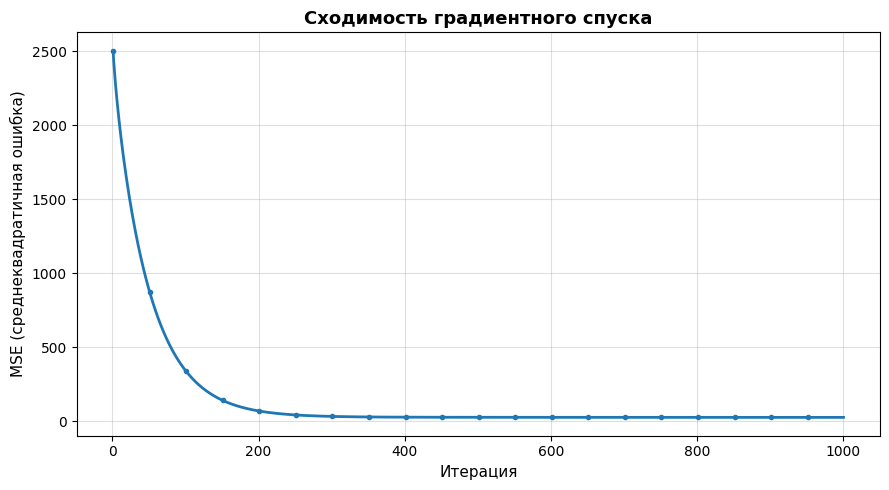


ПРЕДСКАЗАНИЕ НА TEST.CSV



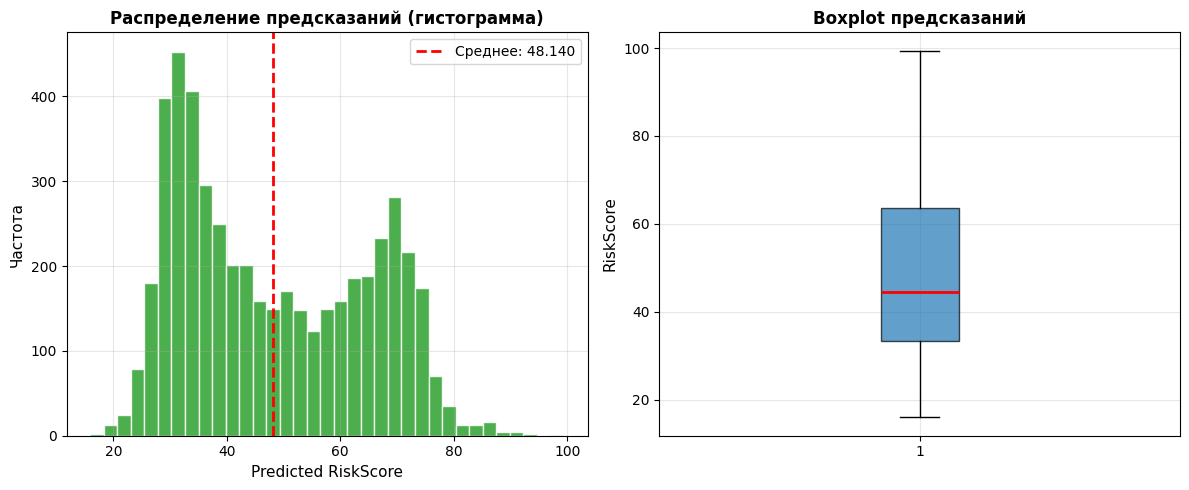


СТАТИСТИКА ПРЕДСКАЗАНИЙ ДЛЯ TEST.CSV:
       Min:   15.9519
       25%:   33.2621
    Median:   44.5054
      Mean:   48.1400
       75%:   63.6429
       Max:   99.4106
       Std:   16.4355
  Skewness:    0.3332

ПРОВЕРКА НА АНОМАЛИИ (метод IQR):
  • Выбросов не обнаружено — распределение корректно.

Файл сабмита сохранён: 'submission.csv'

ПЕРВЫЕ 10 ПРЕДСКАЗАНИЙ:
   ID  RiskScore
0   0  32.824297
1   1  51.634147
2   2  29.807862
3   3  34.878094
4   4  34.948515
5   5  68.397208
6   6  31.095701
7   7  31.782498
8   8  36.534491
9   9  66.190376


In [ ]:
print("=== ОБУЧЕНИЕ МОДЕЛИ И ПРЕДСКАЗАНИЕ ===\n")

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print("Модель: My GD (lr=0.001)")
print(f"Тренировочные данные: {X_train_clean.shape}")


print("\nОбучение модели...")
final_model = MyLinearRegression(method='gd', lr=0.005, max_iter=2000)
final_model.fit(X_train_clean, y_train_clean)

# Оценка на тренировочных данных
y_train_pred = final_model.predict(X_train_clean)
train_metrics = {
    'MSE': mean_squared_error(y_train_clean, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train_clean, y_train_pred)),
    'MAE': mean_absolute_error(y_train_clean, y_train_pred),
    'R2': r2_score(y_train_clean, y_train_pred)
}

print(f"\nМЕТРИКИ НА ТРЕНИРОВОЧНЫХ ДАННЫХ:")
for metric, value in train_metrics.items():
    print(f"  {metric:4}: {value:.6f}")

# === Визуализация сходимости ===
if hasattr(final_model, 'mse_history') and final_model.mse_history:
    mse_hist = np.array(final_model.mse_history)
    n_plot = min(1000, len(mse_hist))
    iterations = np.arange(1, n_plot + 1)

    plt.figure(figsize=(9, 5))
    plt.plot(iterations, mse_hist[:n_plot], 
             color='#1f77b4', linewidth=2, marker='o', markersize=3, markevery=50)
    plt.xlabel('Итерация', fontsize=11)
    plt.ylabel('MSE (среднеквадратичная ошибка)', fontsize=11)
    plt.title('Сходимость градиентного спуска', fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("\nИстория MSE недоступна")

# === Предсказание на тестовых данных ===
print()
print("ПРЕДСКАЗАНИЕ НА TEST.CSV")
print()


y_test_pred = final_model.predict(X_test_norm)

# Создание сабмита
submission = pd.DataFrame({
    "ID": test_ids,
    "RiskScore": y_test_pred
})

# Визуализация распределения предсказаний
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
counts, bins, patches = plt.hist(y_test_pred, bins=35, 
                                  edgecolor='white', alpha=0.85, color='#2ca02c')
plt.axvline(x=y_test_pred.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Среднее: {y_test_pred.mean():.3f}')
plt.xlabel('Predicted RiskScore', fontsize=11)
plt.ylabel('Частота', fontsize=11)
plt.title('Распределение предсказаний (гистограмма)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
bp = plt.boxplot(y_test_pred, vert=True, patch_artist=True,
                 boxprops=dict(facecolor='#1f77b4', color='black', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2))
plt.ylabel('RiskScore', fontsize=11)
plt.title('Boxplot предсказаний', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


print("\nСТАТИСТИКА ПРЕДСКАЗАНИЙ ДЛЯ TEST.CSV:")
stats_dict = {
    'Min': y_test_pred.min(),
    '25%': np.percentile(y_test_pred, 25),
    'Median': np.median(y_test_pred),
    'Mean': y_test_pred.mean(),
    '75%': np.percentile(y_test_pred, 75),
    'Max': y_test_pred.max(),
    'Std': y_test_pred.std(),
    'Skewness': pd.Series(y_test_pred).skew()
}

for stat, value in stats_dict.items():
    print(f"  {stat:>8}: {value:>9.4f}")

# === Проверка на выбросы (метод IQR) ===
print("\nПРОВЕРКА НА АНОМАЛИИ (метод IQR):")
q1 = np.percentile(y_test_pred, 25)
q3 = np.percentile(y_test_pred, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = (y_test_pred < lower_bound) | (y_test_pred > upper_bound)
n_out = outliers.sum()
if n_out > 0:
    print(f"  • Обнаружено выбросов: {n_out} из {len(y_test_pred)} "
          f"({n_out / len(y_test_pred) * 100:.2f} %)")
    print(f"  • Границы нормального диапазона: [{lower_bound:.4f}, {upper_bound:.4f}]")
    outlier_vals = y_test_pred[outliers]
    print(f"  • Примеры экстремальных значений: {np.round(outlier_vals[:5], 4)}")
else:
    print("  • Выбросов не обнаружено — распределение корректно.")

# === Сохранение сабмита ===
output_file = "submission.csv"
submission.to_csv(output_file, index=False)
print(f"\nФайл сабмита сохранён: '{output_file}'")

# Вывод первых 10 строк
print("\nПЕРВЫЕ 10 ПРЕДСКАЗАНИЙ:")
print(submission.head(10))

